In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install pyspark==3.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.3/281.3 MB 5.9 MB/s eta 0:00:00:00:01m0:01m
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 10.1 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805891 sha256=08ff32ac6e83a9b91527aad45a21fa4d67c108eb50c0df9678468a54b2c3f4cc
  Stored in directory: /root/.cache/pip/wheels/32/97/d3/8b6d964c8700e4fbb561c71638a92ec55dac9be51eb5fea86d
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7
  Attempting uninstall: pyspark
    Found existing installation: pyspark 3.5.3
    Uninstalling pyspark-3.5.3:
      Successfully uninstalled pyspark-3.5.3


In [3]:
import pyspark.sql.functions as F
from pyspark.sql.types import StructType, StructField, DoubleType
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
spark = SparkSession.builder.master("local[2]").appName("AnemiaPrediction").getOrCreate()
sc = spark.sparkContext

In [4]:
ANEdata = spark.read.csv("/kaggle/input/anemia-output/output.csv", header=True, inferSchema=True)

# Show the first few rows
ANEdata.show(5)

+---------+--------+---------------+------+------------------+----------------+------------+----------------+------+-------------------------------+------------------------+--------------------+-----------------+
|age_group|location|education_level|status|age_at_first_birth|hemoglobin_level|Anemia_level|mosquito_bed_net|smokes|Currently_residing_with_partner|When_child_put_to_breast|fever_last_two_weeks|Taking_iron_pills|
+---------+--------+---------------+------+------------------+----------------+------------+----------------+------+-------------------------------+------------------------+--------------------+-----------------+
|    25-29|   Urban|      Secondary|  Rich|                25|            95.0|    Moderate|             Yes|    No|                Living with her|                   105.0|                  No|               No|
|    30-34|   Urban|         Higher|  Rich|                30|           113.0|        Mild|             Yes|    No|                Living with her|

In [6]:
ANEdata = ANEdata.withColumnRenamed('Age_group', 'Age_group')
ANEdata = ANEdata.withColumnRenamed('location', 'Residence')
ANEdata = ANEdata.withColumnRenamed('status', 'Wealth_status')
ANEdata = ANEdata.withColumnRenamed('Current marital status','Marital_status')
ANEdata = ANEdata.withColumnRenamed('educational_level', "Mother's_Education_level")
ANEdata = ANEdata.withColumnRenamed('Births in last five years', 'Births_last_five_years') 
ANEdata = ANEdata.withColumnRenamed('Age_at_First_birth', 'Age_of_respondent')
ANEdata = ANEdata.withColumnRenamed('Smokes', 'Smokes_cigarettes') 
ANEdata = ANEdata.withColumnRenamed('Currently residing with husband/partner','Currently_residing_with_husband')

In [7]:
ANEdata.printSchema()

root
 |-- Age_group: string (nullable = true)
 |-- Residence: string (nullable = true)
 |-- education_level: string (nullable = true)
 |-- Wealth_status: string (nullable = true)
 |-- Age_of_respondent: integer (nullable = true)
 |-- hemoglobin_level: double (nullable = true)
 |-- Anemia_level: string (nullable = true)
 |-- mosquito_bed_net: string (nullable = true)
 |-- Smokes_cigarettes: string (nullable = true)
 |-- Currently_residing_with_partner: string (nullable = true)
 |-- When_child_put_to_breast: string (nullable = true)
 |-- fever_last_two_weeks: string (nullable = true)
 |-- Taking_iron_pills: string (nullable = true)



In [ ]:
ANEdat = ANEdata.drop("Hemoglobin level adjusted for altitude (g/dl - 1 decimal)", "births_last_five_years", "Anemia level.1","Currently_residing_with_husband")

In [ ]:
from pyspark.sql.functions import col,isnan, when, count
ANEdat.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in ANEdat.columns]).show()

In [10]:
# Summary statistics for numerical features
ANEdat.describe(["When_child_put_to_breast","Age_of_respondent", "hemoglobin_level"]).show()

+-------+------------------------+-----------------+------------------+
|summary|When_child_put_to_breast|Age_of_respondent|  hemoglobin_level|
+-------+------------------------+-----------------+------------------+
|  count|                    8181|            13136|             13136|
|   mean|      122.30015372790162|19.85809987819732|114.36723507917173|
| stddev|       38.15585805630992|4.420782649782352|15.915408420715405|
|    min|                   102.0|               12|              20.0|
|    max|             Immediately|               45|             218.0|
+-------+------------------------+-----------------+------------------+



In [15]:
# Count unique values in categorical features
categorical_columns = ["Age_group", "Residence", "Wealth_status", "Mosquito_bed_net", "Smokes_cigarettes",
                       "Education_level","Fever_last_two_weeks", "Taking_iron_pills", "Anemia_level","When_child_put_to_breast"]
for column in categorical_columns:
    ANEdat.groupBy(column).count().orderBy("count", ascending=False).show()

+---------+-----+
|Age_group|count|
+---------+-----+
|    25-29| 3704|
|    30-34| 3046|
|    20-24| 2339|
|    35-39| 2259|
|    40-44|  894|
|    15-19|  526|
|    45-49|  368|
+---------+-----+

+---------+-----+
|Residence|count|
+---------+-----+
|    Rural| 8196|
|    Urban| 4940|
+---------+-----+

+-------------+-----+
|Wealth_status|count|
+-------------+-----+
|         Poor| 5477|
|         Rich| 4761|
|       Middle| 2898|
+-------------+-----+

+----------------+-----+
|Mosquito_bed_net|count|
+----------------+-----+
|             Yes| 9135|
|              No| 4001|
+----------------+-----+

+-----------------+-----+
|Smokes_cigarettes|count|
+-----------------+-----+
|               No|13107|
|              Yes|   29|
+-----------------+-----+

+---------------+-----+
|Education_level|count|
+---------------+-----+
|   No education| 5206|
|      Secondary| 4596|
|        Primary| 2195|
|         Higher| 1139|
+---------------+-----+

+--------------------+-----+
|Fever_

In [16]:
ANEdat = ANEdat.withColumn(
    "Fever_last_two_weeks",
    when(col("Fever_last_two_weeks") == "Don't know", "No").otherwise(col("Fever_last_two_weeks"))
)
# Verify the replacements
ANEdat.groupBy("Fever_last_two_weeks").count().orderBy("count", ascending=False).show()

+--------------------+-----+
|Fever_last_two_weeks|count|
+--------------------+-----+
|                  No|10102|
|                 Yes| 3034|
+--------------------+-----+



In [17]:
ANEdat=ANEdat.withColumn(
    "Taking_iron_pills",
    when(col("Taking_iron_pills") == "Don't know", "No").otherwise(col("Taking_iron_pills"))
)
# Verify the replacements
ANEdat.groupBy("Taking_iron_pills").count().orderBy("count", ascending=False).show()

+-----------------+-----+
|Taking_iron_pills|count|
+-----------------+-----+
|               No|10911|
|              Yes| 2225|
+-----------------+-----+



In [18]:
df= ANEdat.fillna({"fever_last_two_weeks": "No","Taking_iron_pills": "No", "When_child_put_to_breast": "Immediately"})
df.show()

+---------+---------+---------------+-------------+-----------------+----------------+------------+----------------+-----------------+-------------------------------+------------------------+--------------------+-----------------+
|Age_group|Residence|education_level|Wealth_status|Age_of_respondent|hemoglobin_level|Anemia_level|mosquito_bed_net|Smokes_cigarettes|Currently_residing_with_partner|When_child_put_to_breast|Fever_last_two_weeks|Taking_iron_pills|
+---------+---------+---------------+-------------+-----------------+----------------+------------+----------------+-----------------+-------------------------------+------------------------+--------------------+-----------------+
|    25-29|    Urban|      Secondary|         Rich|               25|            95.0|    Moderate|             Yes|               No|                Living with her|                   105.0|                  No|               No|
|    30-34|    Urban|         Higher|         Rich|               30|       

In [21]:

from pyspark.sql import functions as F
from pyspark.sql.window import Window  # Import the Window function

# List of variables to compare with the target variable (anemia level)
columns_to_compare = ["Residence", "Wealth_status", "Mosquito_bed_net", "Smokes_cigarettes", 
                     "Education_level", "Fever_last_two_weeks", 
                      "Taking_iron_pills", "When_child_put_to_breast"]

# Loop through each variable and calculate percentages for each anemia level
for column in columns_to_compare:
    print(f"Anemia distribution by {column}")
    
    result = (
        df.groupBy(column, "Anemia_level")  # Group by the column and anemia level
              .count()  # Count occurrences
              .withColumn("total", F.sum("count").over(Window.partitionBy(column)))  # Get total for each group
              .withColumn("percentage", F.round((F.col("count") / F.col("total")) * 100, 2))  # Calculate percentage
              .orderBy(column, "Anemia_level")  # Sort results
    )
    
    result.show(truncate=False)


Anemia distribution by Residence
+---------+------------+-----+-----+----------+
|Residence|Anemia_level|count|total|percentage|
+---------+------------+-----+-----+----------+
|Rural    |Mild        |2296 |8196 |28.01     |
|Rural    |Moderate    |2663 |8196 |32.49     |
|Rural    |Not anemic  |3077 |8196 |37.54     |
|Rural    |Severe      |160  |8196 |1.95      |
|Urban    |Mild        |1298 |4940 |26.28     |
|Urban    |Moderate    |1311 |4940 |26.54     |
|Urban    |Not anemic  |2260 |4940 |45.75     |
|Urban    |Severe      |71   |4940 |1.44      |
+---------+------------+-----+-----+----------+

Anemia distribution by Wealth_status
+-------------+------------+-----+-----+----------+
|Wealth_status|Anemia_level|count|total|percentage|
+-------------+------------+-----+-----+----------+
|Middle       |Mild        |840  |2898 |28.99     |
|Middle       |Moderate    |874  |2898 |30.16     |
|Middle       |Not anemic  |1136 |2898 |39.2      |
|Middle       |Severe      |48   |2898 |1

In [22]:
explain the result concentrating more on the or percentage of severe for each group in it's own  level.. for example; rural residents have 60 or 80 0r whatever percentage of severe casees while urban has lesser percentages of severe anemia it also show that more percentageof moderate leaves in rural area e.t.c.

SyntaxError: unterminated string literal (detected at line 1) (<ipython-input-22-5d655f7ea12d>, line 1)

In [23]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---------+---------+---------------+-------------+-----------------+----------------+------------+----------------+-----------------+-------------------------------+------------------------+--------------------+-----------------+
|Age_group|Residence|education_level|Wealth_status|Age_of_respondent|hemoglobin_level|Anemia_level|mosquito_bed_net|Smokes_cigarettes|Currently_residing_with_partner|When_child_put_to_breast|Fever_last_two_weeks|Taking_iron_pills|
+---------+---------+---------------+-------------+-----------------+----------------+------------+----------------+-----------------+-------------------------------+------------------------+--------------------+-----------------+
|        0|        0|              0|            0|                0|               0|           0|               0|                0|                            724|                       0|                   0|                0|
+---------+---------+---------------+-------------+-----------------+-------

In [24]:
# Import necessary visualization libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Set the style of seaborn plots
sns.set(style="whitegrid")

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


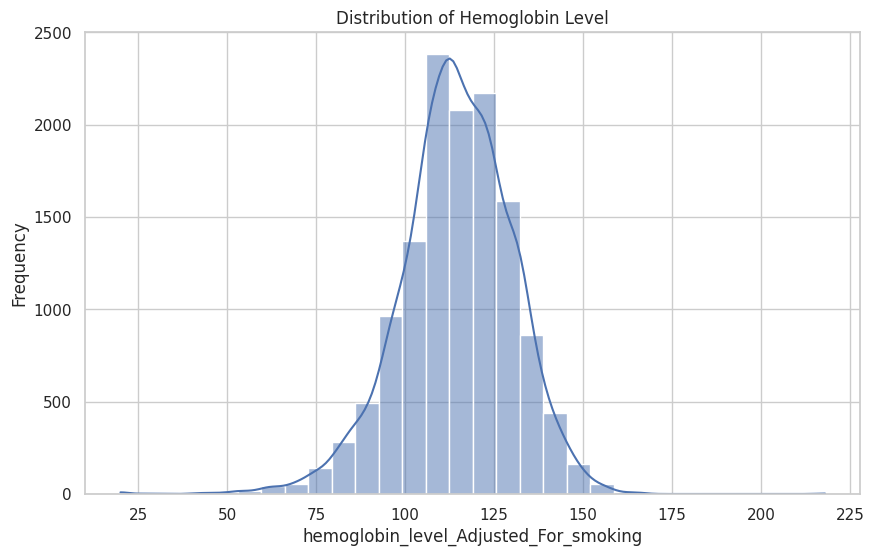

In [26]:
# Histogram for numerical features
plt.figure(figsize=(10, 6))
sns.histplot(pandas_df['hemoglobin_level'], bins=30, kde=True)
plt.title('Distribution of Hemoglobin Level')
plt.xlabel('hemoglobin_level_Adjusted_For_smoking')
plt.ylabel('Frequency')
plt.show()

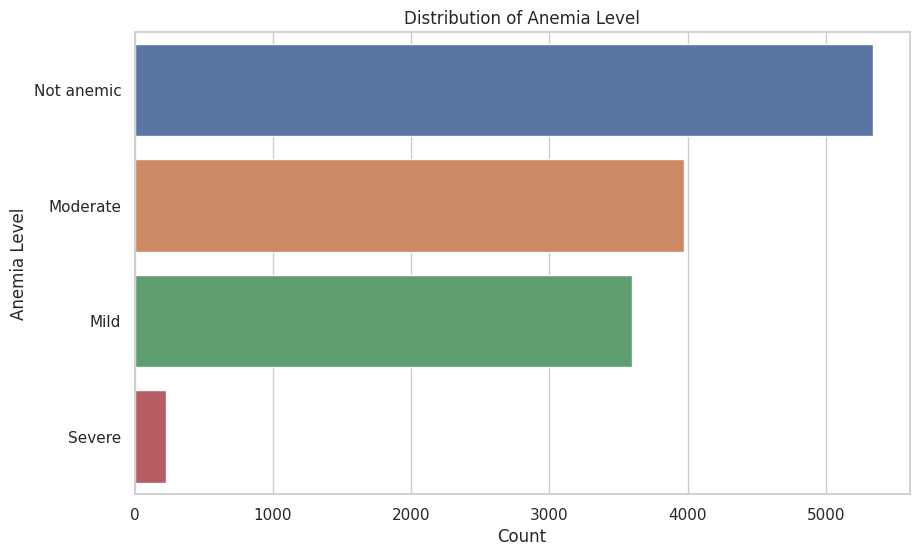

In [27]:
# Bar chart for categorical features
plt.figure(figsize=(10, 6))
sns.countplot(y='Anemia_level', data=pandas_df, order=pandas_df['Anemia_level'].value_counts().index)
plt.title('Distribution of Anemia Level')
plt.xlabel('Count')
plt.ylabel('Anemia Level')
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

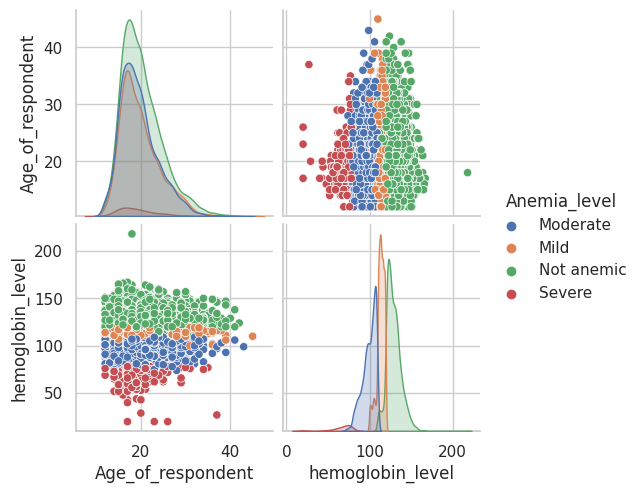

In [28]:
# Pairplot to see relationships between features
sns.pairplot(pandas_df, hue='Anemia_level', diag_kind='kde')
plt.show()

In [30]:
import numpy as np

In [32]:
print(pandas_df.dtypes)

Age_group                           object
Residence                           object
education_level                     object
Wealth_status                       object
Age_of_respondent                    int32
hemoglobin_level                   float64
Anemia_level                        object
mosquito_bed_net                    object
Smokes_cigarettes                   object
Currently_residing_with_partner     object
When_child_put_to_breast            object
Fever_last_two_weeks                object
Taking_iron_pills                   object
dtype: object


In [33]:
numerical_df = pandas_df.select_dtypes(include=[np.number])

In [34]:
print(numerical_df.columns)

Index(['Age_of_respondent', 'hemoglobin_level'], dtype='object')


In [36]:
# Compute the correlation matrix
correlation_matrix = numerical_df.corr()

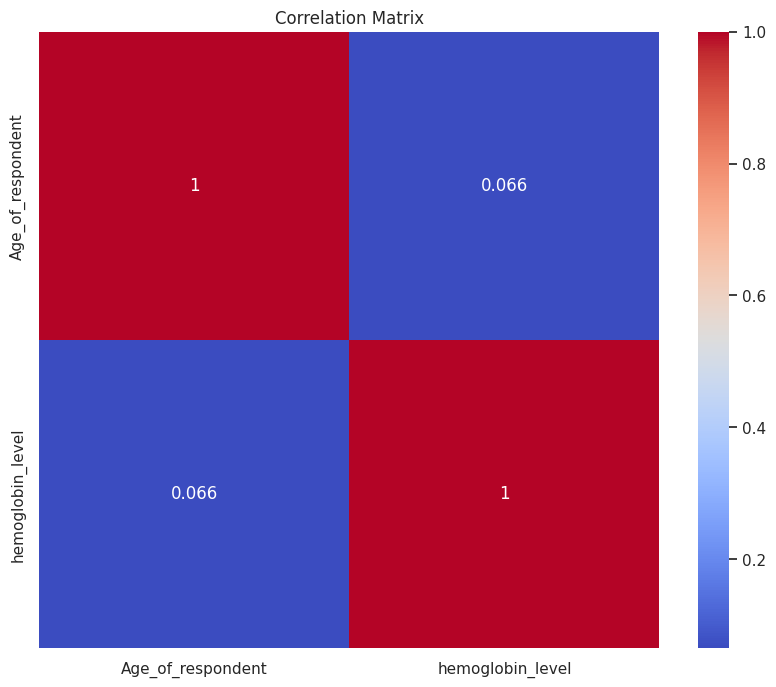

In [37]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [38]:
from pyspark.sql.functions import col, isnan, when, count, avg

In [39]:
# Group by 'Anemia_level' and calculate mean of 'hemoglobin_level'
grouped_data = df.groupBy("Anemia_level").agg(avg("hemoglobin_level").alias("avg_hemoglobin_level_Adjusted_For_smoking"))
grouped_data.show()

+------------+-----------------------------------------+
|Anemia_level|avg_hemoglobin_level_Adjusted_For_smoking|
+------------+-----------------------------------------+
|  Not anemic|                       128.67978264942852|
|      Severe|                        66.58874458874459|
|        Mild|                       113.04785754034502|
|    Moderate|                        99.11625566180172|
+------------+-----------------------------------------+



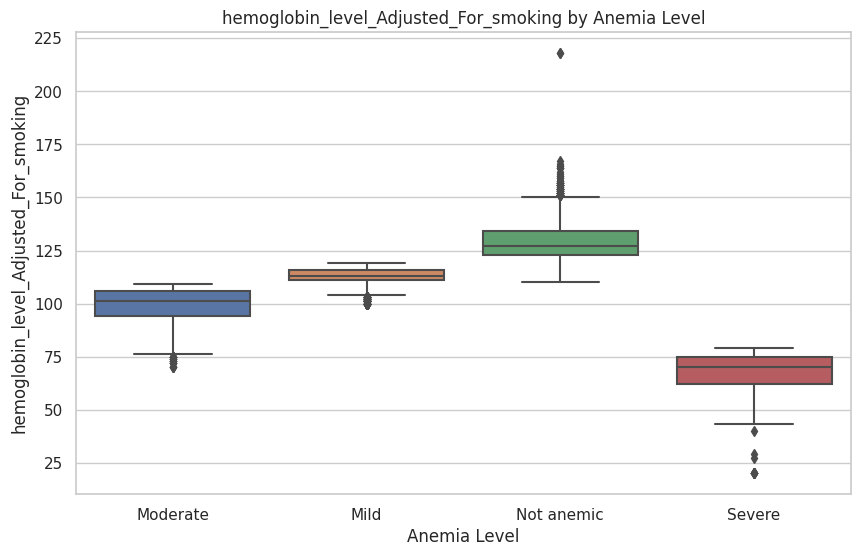

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Anemia_level', y='hemoglobin_level', data=pandas_df)
plt.title('hemoglobin_level_Adjusted_For_smoking by Anemia Level')
plt.xlabel('Anemia Level')
plt.ylabel('hemoglobin_level_Adjusted_For_smoking')
plt.show()

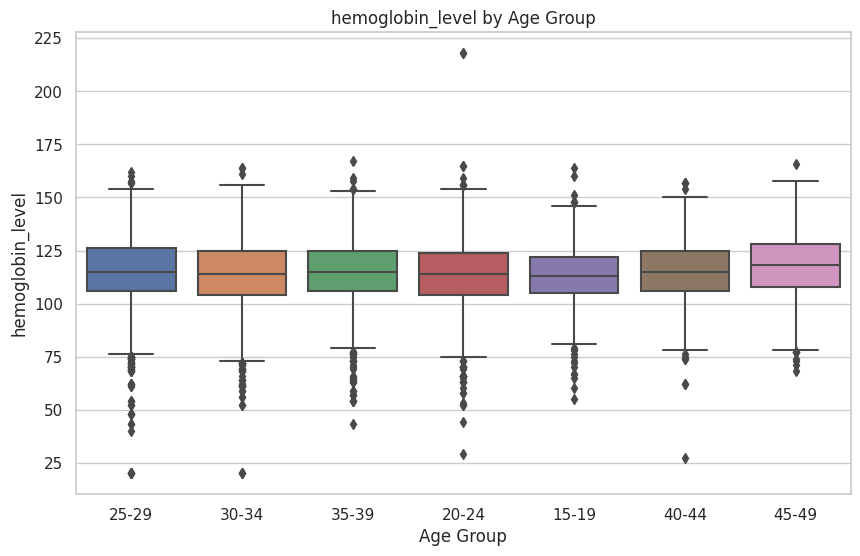

In [41]:
# Visualize relationship between 'age_group' and 'hemoglobin_level'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_group', y='hemoglobin_level', data=pandas_df)
plt.title('hemoglobin_level by Age Group')
plt.xlabel('Age Group')
plt.ylabel('hemoglobin_level')
plt.show()

In [42]:
# Group by 'age_group' and 'Anemia_level' to get counts
age_anemia_counts = df.groupBy("Age_group", "Anemia_level").count().orderBy("Age_group")

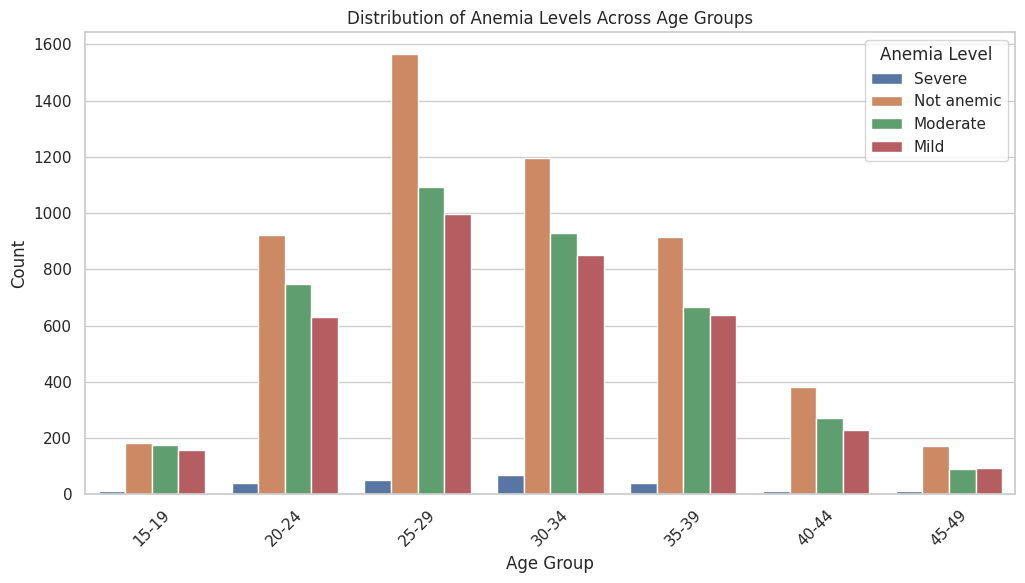

In [43]:
age_anemia_pd = age_anemia_counts.toPandas()

# Plot the distribution
plt.figure(figsize=(12, 6))
sns.barplot(x='Age_group', y='count', hue='Anemia_level', data=age_anemia_pd)
plt.title('Distribution of Anemia Levels Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Anemia Level')
plt.show()


In [39]:
location_anemia_counts = df.groupBy("Residence", "Anemia_level").count().orderBy("Residence")

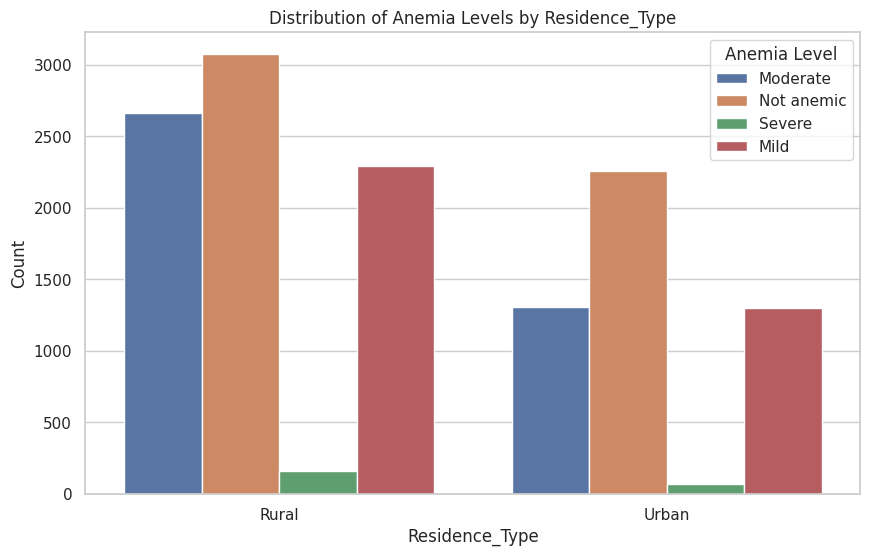

In [40]:
# Convert to Pandas DataFrame for plotting
location_anemia_pd = location_anemia_counts.toPandas()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Residence', y='count', hue='Anemia_level', data=location_anemia_pd)
plt.title('Distribution of Anemia Levels by Residence_Type')
plt.xlabel('Residence_Type')
plt.ylabel('Count')
plt.legend(title='Anemia Level')
plt.show()

In [41]:
# Group by 'smokes' and 'Anemia_level' to get counts
Smokes_anemia_counts = df.groupBy("Smokes_cigarettes", "Anemia_level").count().orderBy("Smokes_cigarettes")

In [42]:
# Convert to Pandas DataFrame for plotting
Smokes_anemia_pd = Smokes_anemia_counts.toPandas()

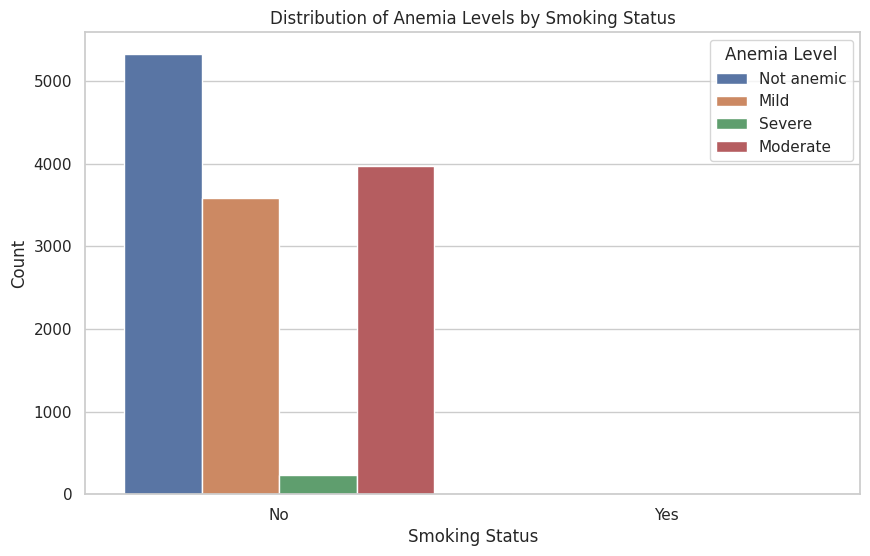

In [43]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Smokes_cigarettes', y='count', hue='Anemia_level', data=Smokes_anemia_pd)
plt.title('Distribution of Anemia Levels by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Count')
plt.legend(title='Anemia Level')
plt.show()

In [44]:
iron_pills_anemia_counts = df.groupBy("Taking_iron_pills", "Anemia_level").count().orderBy("Taking_iron_pills")

# Convert to Pandas DataFrame for plotting
iron_pills_anemia_pd = iron_pills_anemia_counts.toPandas()

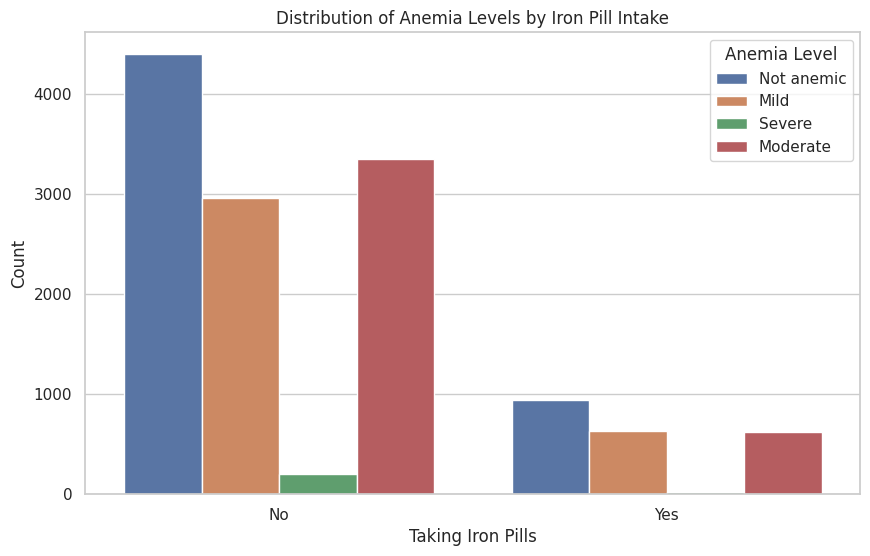

In [45]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Taking_iron_pills', y='count', hue='Anemia_level', data=iron_pills_anemia_pd)
plt.title('Distribution of Anemia Levels by Iron Pill Intake')
plt.xlabel('Taking Iron Pills')
plt.ylabel('Count')
plt.legend(title='Anemia Level')
plt.show()

In [58]:
# Group by 'mosquito_bed_net' and 'Anemia_level' to get counts
bednet_anemia_counts = df.groupBy("mosquito_bed_net", "Anemia_level").count().orderBy("mosquito_bed_net")

# Convert to Pandas DataFrame for plotting
bednet_anemia_pd = bednet_anemia_counts.toPandas()


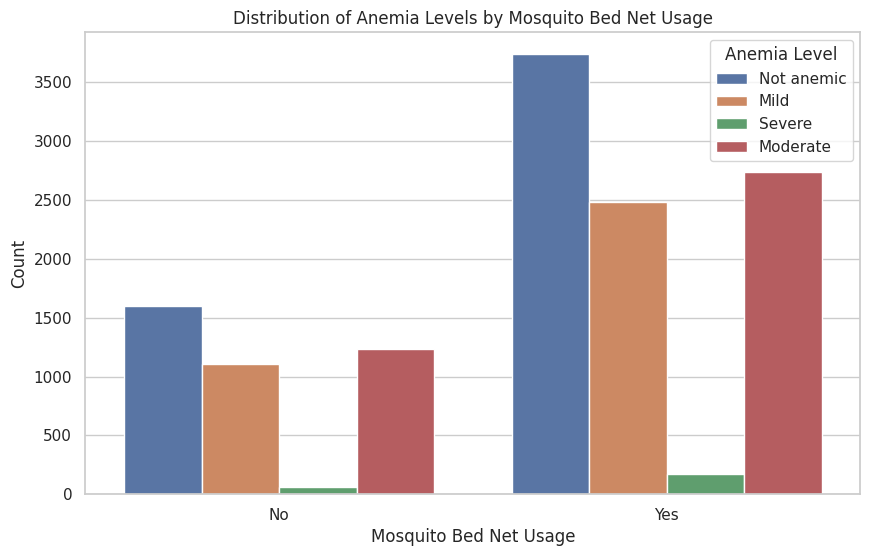

In [59]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='mosquito_bed_net', y='count', hue='Anemia_level', data=bednet_anemia_pd)
plt.title('Distribution of Anemia Levels by Mosquito Bed Net Usage')
plt.xlabel('Mosquito Bed Net Usage')
plt.ylabel('Count')
plt.legend(title='Anemia Level')
plt.show()

In [52]:
# Group by 'Mother's_Education_level' and 'Anemia_level' to get counts, ordered by 'Mother's_Education_level'
Education_anemia_counts = df.groupBy("Mother's_Education_level", "Anemia_level").count().orderBy("Mother's_Education_level")

# Convert to Pandas DataFrame for plotting
Education_anemia_pd = Education_anemia_counts.toPandas()

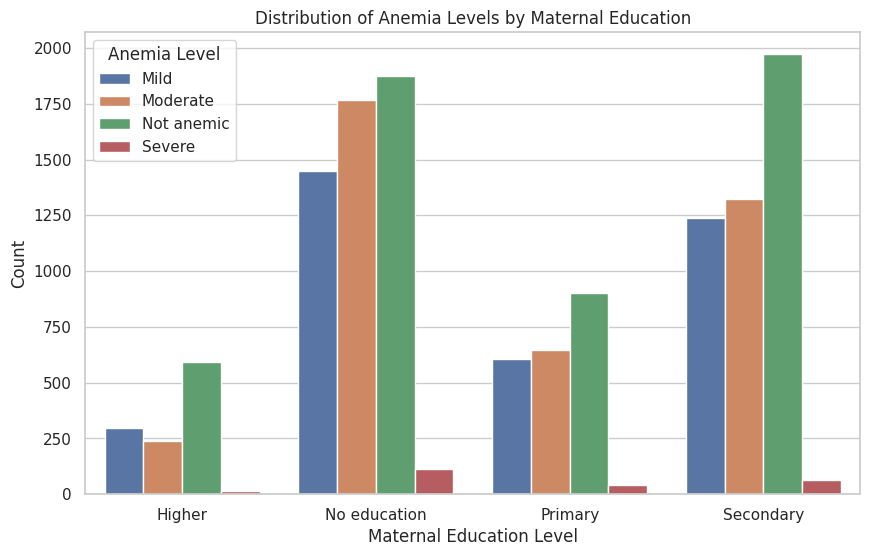

In [57]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x="Mother's_Education_level", y='count', hue='Anemia_level', data=Education_anemia_pd)
plt.title('Distribution of Anemia Levels by Maternal Education')
plt.xlabel('Maternal Education Level')
plt.ylabel('Count')
plt.legend(title='Anemia Level')
plt.show()

In [44]:
Wealth_status_anemia_counts = df.groupBy("Wealth_status", "Anemia_level").count().orderBy("Wealth_status")

# Convert to Pandas DataFrame for plotting
Wealth_status_anemia_pd = Wealth_status_anemia_counts.toPandas()

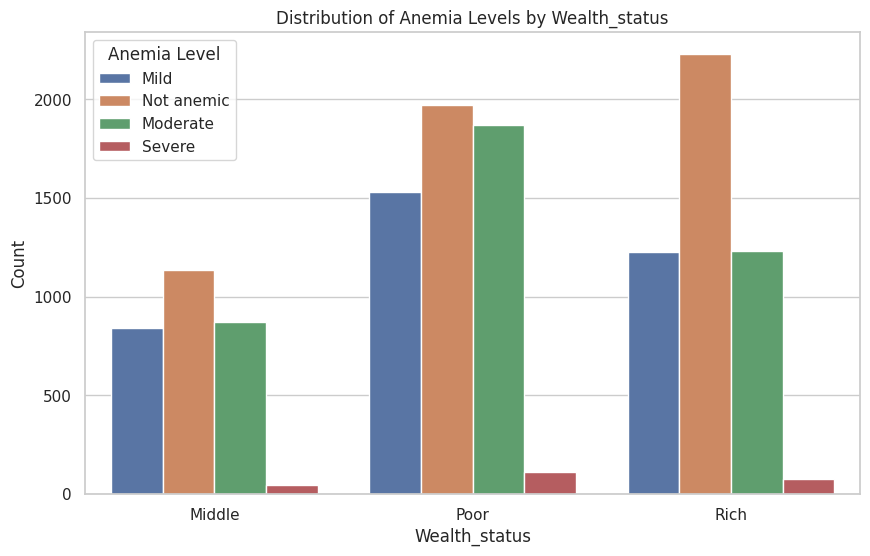

In [45]:
# Plot the distribution
plt.figure(figsize=(10, 6))
sns.barplot(x='Wealth_status', y='count', hue='Anemia_level', data=Wealth_status_anemia_pd)
plt.title('Distribution of Anemia Levels by Wealth_status')
plt.xlabel('Wealth_status')
plt.ylabel('Count')
plt.legend(title='Anemia Level')
plt.show()